<a href="https://colab.research.google.com/github/Monika303/Bank_Account_System/blob/master/ERS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion Recognition with FER2013

This project uses a Convolutional Neural Network (CNN) to classify facial emotions from the FER2013 dataset. Data augmentation is applied to improve model performance.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from google.colab import files
uploaded = files.upload()  # upload fer2013.csv

Saving fer2013.csv.xlsx to fer2013.csv.xlsx


In [ ]:
# Read excedl
df = pd.read_excel('fer2013.csv.xlsx')

In [ ]:
# Define a mapping from emotion names to their numerical IDs
emotion_name_to_id = {
    'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Sad': 4, 'Surprise': 5, 'Neutral': 6,
    'anger': 0, 'disgust': 1, 'fear': 2, 'happiness': 3, 'sadness': 4, 'surprise': 5, 'neutral': 6
}

##Data visualisation

In [ ]:
# Show basic info
print("\nDataset info:")
print(df.info())



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   emotion       35887 non-null  int64 
 1   pixels        35887 non-null  object
 2   Usage         35887 non-null  object
 3   emotion_name  35887 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.1+ MB
None


In [ ]:
# Count of images per emotion
print("\nNumber of images per emotion:")
print(df['emotion'].value_counts())


Number of images per emotion:
emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64


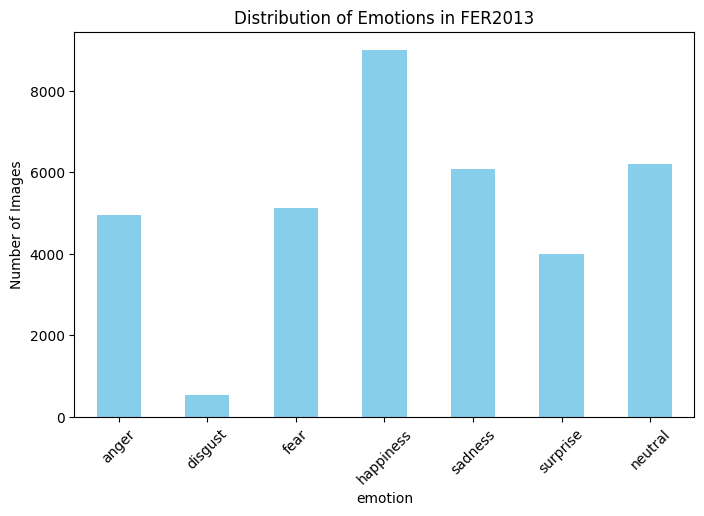

In [ ]:
# Plot distribution of emotions
emotion_labels = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral']
plt.figure(figsize=(8,5))
df['emotion'].value_counts().reindex(range(7)).plot(kind='bar', color='skyblue')
plt.xticks(ticks=range(7), labels=emotion_labels, rotation=45)
plt.title("Distribution of Emotions in FER2013")
plt.ylabel("Number of Images")
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='emotion', data=df, palette='Set2')
plt.title("Distribution of Emotions in FER2013 Dataset")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()


/tmp/ipython-input-2046546420.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='emotion', data=df, palette='Set2')


In [ ]:
# Distribution per usage type (Training, PublicTest, PrivateTest)
plt.figure(figsize=(10,5))
sns.countplot(x='emotion', hue='Usage', data=df, palette='Set3')
plt.title("Emotion Distribution by Dataset Split")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.legend(title='Usage')
plt.show()

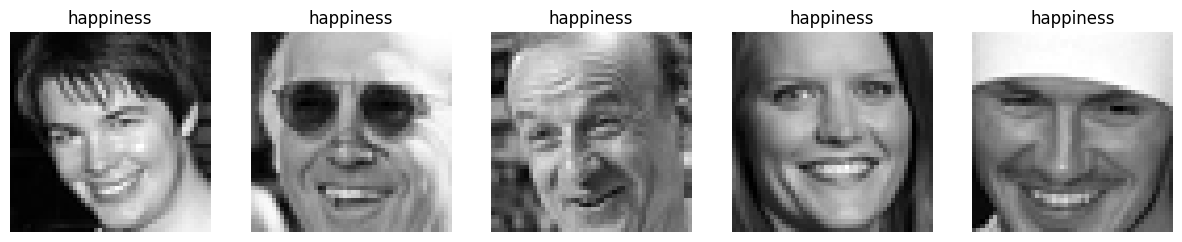

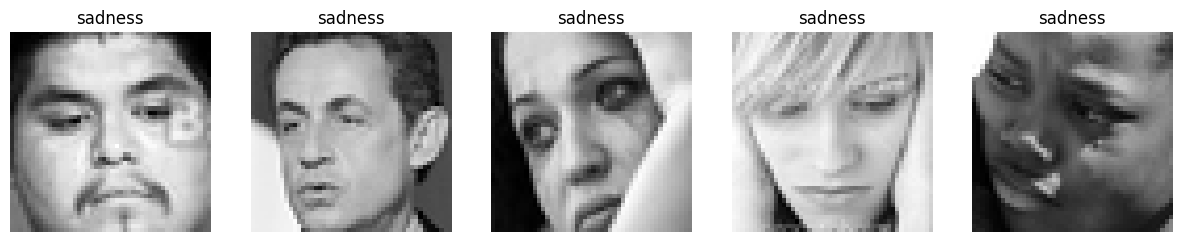

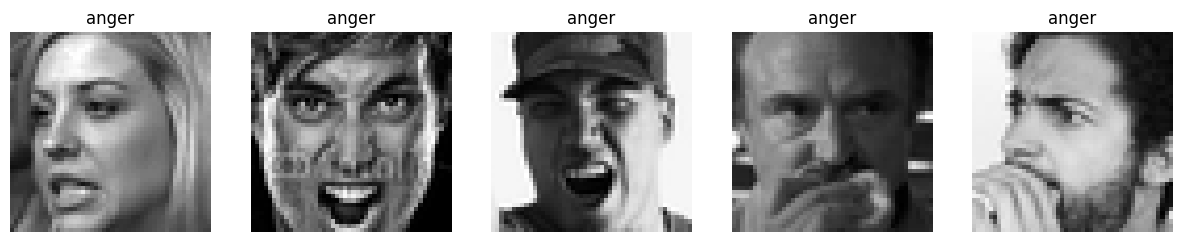

In [ ]:

#  Function to show sample images
def show_sample_images(df, emotion_name, num_samples=5):
    subset = df[df['emotion_name'] == emotion_name]

    if len(subset) == 0:
        print(f"No samples found for emotion '{emotion_name}'")
        return

    sample = subset.sample(min(num_samples, len(subset)))  # avoid errors if fewer rows exist

    plt.figure(figsize=(15, 3))
    for i, row in enumerate(sample.itertuples()):
        pixels = np.array([int(p) for p in row.pixels.split()]).reshape(48,48)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(pixels, cmap='gray')
        plt.title(emotion_name)
        plt.axis('off')
    plt.show()

#  Example usage
show_sample_images(df, 'happiness', num_samples=5)
show_sample_images(df, 'sadness', num_samples=5)
show_sample_images(df, 'anger', num_samples=5)

In [ ]:
# Split data based on Usage
df_train = df[df['Usage'] == 'Training']
df_public_test = df[df['Usage'] == 'PublicTest']
df_private_test = df[df['Usage'] == 'PrivateTest']

In [ ]:
# Features and labels
X_train = df_train['pixels']
y_train = df_train['emotion']

X_public_test = df_public_test['pixels']
y_public_test = df_public_test['emotion']

X_private_test = df_private_test['pixels']
y_private_test = df_private_test['emotion']

##Data Preprocessing

In [ ]:

def process_pixels(pixel_series):
    # Convert string of pixels to numpy arrays
    return np.array([np.array(list(map(int, p.split()))) for p in pixel_series])

# Normalize
X_train = process_pixels(X_train) / 255.0
X_public_test = process_pixels(X_public_test) / 255.0
X_private_test = process_pixels(X_private_test) / 255.0

# Reshape for CNN (48x48 grayscale)
IMG_WIDTH, IMG_HEIGHT = 48, 48
X_train = X_train.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)
X_public_test = X_public_test.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)
X_private_test = X_private_test.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)

# One-hot encode labels
num_classes = 7
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes)
y_public_test_encoded = tf.keras.utils.to_categorical(y_public_test, num_classes)
y_private_test_encoded = tf.keras.utils.to_categorical(y_private_test, num_classes)

## Convolutional Neural Network (CNN)

In [ ]:
#3. Build CNN Model with Input Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model = Sequential([
    Input(shape=(48,48,1)),
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,422,087 (5.42 MB)

 Trainable params: 1,421,191 (5.42 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# === 4. Callbacks for saving best model and early stopping ===
checkpoint = ModelCheckpoint(
    'best_emotion_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1
)
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)


## Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=10,  #Rotation up to 10 degrees
    horizontal_flip=True, #Horizontal shift (10% of width)
    fill_mode='nearest' # How to fill in empty pixels after transformations
)

## Model Training

In [ ]:
# === 5. Train the model ===
history_augmented = model.fit(
    datagen.flow(X_train, y_train_encoded, batch_size=64),
    epochs=50,
    validation_data=(X_public_test, y_public_test_encoded),
    callbacks=[checkpoint, early_stop],
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2446 - loss: 2.1620
Epoch 1: val_accuracy improved from -inf to 0.31123, saving model to best_emotion_model.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 479s 1s/step - accuracy: 0.2447 - loss: 2.1612 - val_accuracy: 0.3112 - val_loss: 1.7445
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 997ms/step - accuracy: 0.3583 - loss: 1.6177
Epoch 2: val_accuracy improved from 0.31123 to 0.44692, saving model to best_emotion_model.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 496s 1s/step - accuracy: 0.3583 - loss: 1.6177 - val_accuracy: 0.4469 - val_loss: 1.4651
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 992ms/step - accuracy: 0.4000 - loss: 1.5304
Epoch 3: val_accuracy did not improve from 0.44692
449/449 ━━━━━━━━━━━━━━━━━━━━ 456s 1s/step - accuracy: 0.4000 - loss: 1.5304 - val_accuracy: 0.3887 - val_loss: 1.5565
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 994ms/step - accuracy: 0.4095 - loss: 1.5038
Epoch 4: val_accuracy did not improve from 0.44692
449/

In [ ]:
from google.colab import drive
import shutil
import os

drive.mount('/content/drive')

drive_path = '/content/drive/MyDrive/Emotion_Recognition_Project'
os.makedirs(drive_path, exist_ok=True)

shutil.copy('best_emotion_model.keras', os.path.join(drive_path, 'best_emotion_model.keras'))
print("Model saved to Google Drive!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to Google Drive!


In [ ]:
import pickle

emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
with open(os.path.join(drive_path, 'emotion_labels.pkl'), 'wb') as f:
    pickle.dump(emotion_labels, f)


## Model Evaluation

In [ ]:
test_loss, test_acc = model.evaluate(X_private_test, y_private_test_encoded)
print("Private Test Accuracy:", test_acc)
print("Private Test Loss:", test_loss)

113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.6102 - loss: 1.0416
Private Test Accuracy: 0.61521315574646
Private Test Loss: 1.0253432989120483


##  Training Visualizations

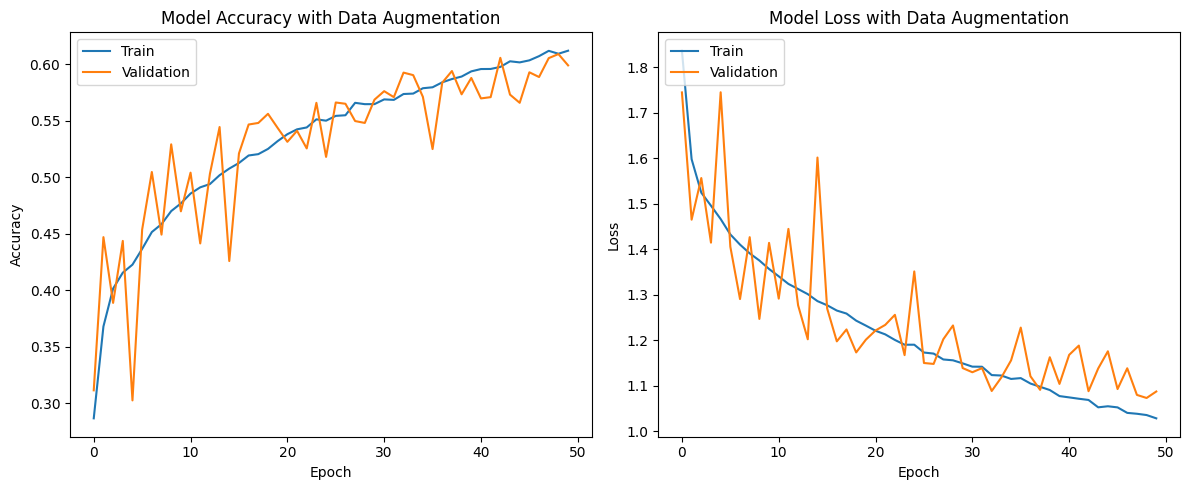

In [ ]:
#Plot Accuracy and Loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_augmented.history['accuracy'])
plt.plot(history_augmented.history['val_accuracy'])
plt.title('Model Accuracy with Data Augmentation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_augmented.history['loss'])
plt.plot(history_augmented.history['val_loss'])
plt.title('Model Loss with Data Augmentation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
# Confusion Matrix & Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

CLASS_NAMES = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
y_true = np.argmax(y_private_test_encoded, axis=1)
y_pred = np.argmax(model.predict(X_private_test), axis=1)

print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 179ms/step
              precision    recall  f1-score   support

       Angry       0.64      0.46      0.53       491
     Disgust       0.88      0.25      0.39        55
        Fear       0.44      0.29      0.35       528
       Happy       0.84      0.85      0.85       879
         Sad       0.44      0.53      0.48       594
    Surprise       0.75      0.74      0.75       416
     Neutral       0.52      0.71      0.60       626

    accuracy                           0.62      3589
   macro avg       0.64      0.55      0.56      3589
weighted avg       0.62      0.62      0.61      3589



In [ ]:
from google.colab import files

# Upload multiple files at once
uploaded = files.upload()

# Check which files were uploaded
for filename in uploaded.keys():
    print("Uploaded file:", filename)


Saving best_emotion_model.keras to best_emotion_model (1).keras
Uploaded file: best_emotion_model (1).keras


In [ ]:
from google.colab import files
from tensorflow.keras.models import load_model

# Upload your model
uploaded = files.upload()  # select emotion_model_augmented.keras from your computer

# Load the uploaded model
for filename in uploaded.keys():
    model = load_model(filename)
    print(f"Loaded model: {filename}")


Saving best_emotion_model.keras to best_emotion_model (2).keras
Loaded model: best_emotion_model (2).keras


## Predicting Emotions on New Images

In [ ]:
# --- Required imports ---
from google.colab import files
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from IPython.display import Audio, display

# --- Load your trained model ---
model = load_model("best_emotion_model.keras")

# --- FER2013 emotion labels ---
emotion_labels = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral']

# --- Prediction and music function ---
def predict_emotion_play_song(img_path):
    # Load and preprocess the image
    img = Image.open(img_path).convert('L')
    img_resized = img.resize((48, 48))
    img_array = np.array(img_resized).astype('float32') / 255.0
    img_array = np.expand_dims(img_array, axis=(0, -1))

    # Predict emotion
    prediction = model.predict(img_array)
    predicted_emotion = emotion_labels[np.argmax(prediction)]

    # Show results
    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {predicted_emotion}")
    plt.axis('off')
    plt.show()

    # Play happy song if detected
    if predicted_emotion == 'happiness':
        print("Playing happy song!")
        display(Audio("happy.mp3", autoplay=True))

# --- Upload image ---
uploaded = files.upload()
for filename in uploaded.keys():
    print("Uploaded image:", filename)

# --- Run prediction on the uploaded image ---
for img_filename in uploaded.keys():
    predict_emotion_play_song(img_filename)

Saving Training_1206.jpg to Training_1206 (2).jpg
Uploaded image: Training_1206 (2).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Playing happy song!


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving sad.mp3 to sad.mp3
Saving surprise.mp3 to surprise.mp3


In [ ]:
# --- Required imports ---
from google.colab import files
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from IPython.display import Audio, display

# --- Load your trained model ---
model = load_model("best_emotion_model.keras")

# --- Define emotion labels and corresponding songs ---
emotion_labels = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral']
emotion_songs = {
    'anger': 'angry.mp3',
    'disgust': 'disgust.mp3',
    'fear': 'fear.mp3',
    'happiness': 'happy.mp3',
    'sadness': 'sad.mp3',
    'surprise': 'surprise.mp3',
    'neutral': 'natural.org.mp3'
}

# --- Prediction function ---
def predict_emotion(img_path):
    # Load and preprocess the image
    img = Image.open(img_path).convert('L')
    img_resized = img.resize((48, 48))
    img_array = np.array(img_resized).astype('float32') / 255.0
    img_array = np.expand_dims(img_array, axis=(0, -1))

    # Predict emotion
    prediction = model.predict(img_array)
    predicted_emotion = emotion_labels[np.argmax(prediction)]

    # Display image with prediction
    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {predicted_emotion}")
    plt.axis('off')
    plt.show()

    # Play the corresponding song
    song_file = emotion_songs[predicted_emotion]
    print(f"Playing song for {predicted_emotion}: {song_file}")
    display(Audio(song_file, autoplay=True))

# --- Upload and predict for multiple images ---
num_photos = int(input("How many photos do you want to upload? "))

for _ in range(num_photos):
    print("\nUpload a photo:")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print("Uploaded:", filename)
        predict_emotion(filename)


How many photos do you want to upload? 1

Upload a photo:


Saving Training_3908.jpg to Training_3908.jpg
Uploaded: Training_3908.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Playing song for anger: angry.mp3
